In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
import keras
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline
from numpy import load

In [ ]:
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/'

In [ ]:
import pandas as pd
df = pd.read_csv(path + 'media/train.csv')

In [ ]:
df = df.replace(to_replace =['Cr1', 'Cr2', 'Cr3', 'Cr4', 'Cr5', 'Cr6', 'Cr7', 'Cr8', 'Cr9',
       'Cr10'], value ='adenocarcinoma')

In [ ]:
#change string to np array
df['points'] = df['points'].apply(lambda x: np.array(eval(x)), 0)

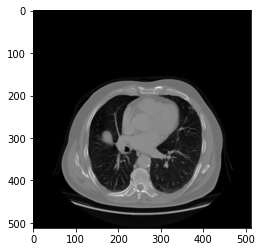

In [ ]:
import cv2
origImage = cv2.imread(path  + df['image'][0])
origImage = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY, )
plt.imshow(origImage,cmap = "gray")

In [ ]:
num = df['name'].unique()

In [ ]:
df1 = df
for i in range(len(df['name'])):
    for j in range(len(num)):
        if df['name'][i] == num[j]:
            df1['name'][i] = j

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
from tqdm import tqdm
from matplotlib.path import Path
ar = []
for ind in tqdm(range(len(df['image']))):
    tupVerts= df['points'][ind]


    x, y = np.meshgrid(np.arange(origImage.shape[0]), np.arange(origImage.shape[1])) # make a canvas with coordinates
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T 

    p = Path(tupVerts) # make a polygon
    grid = p.contains_points(points)
    mask = grid.reshape(origImage.shape[0],origImage.shape[0]) # now you have a mask with points inside a polygon
    ar.append(mask)
df['mask'] = ar

100%|██████████| 534/534 [00:24<00:00, 21.38it/s]


In [ ]:
ar = []
for ind in tqdm(range(len(df['image']))):
    origImage = cv2.imread(path  + df['image'][ind])
    origImage = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY, )
    ar.append(origImage)
df['img'] = ar

100%|██████████| 534/534 [00:03<00:00, 167.58it/s]


In [ ]:
x = []
y = []
z = []
for ind in tqdm(range(len(df))):
    x.append(df['img'][ind])
    y.append(df['mask'][ind])
    z.append(df['name'][ind])

100%|██████████| 534/534 [00:00<00:00, 52305.14it/s]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2, random_state=10)

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
class MyDataset(Dataset):
    def __init__(self, data, targets, label, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.label = label
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        z = self.label[index]
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y, z

    def __len__(self):
        return len(self.data)
%matplotlib inline
transform = transforms.Compose([transforms.ToTensor()])
dataset = MyDataset(X_train,y_train, z_train, transform=transform)
trainloader = DataLoader(dataset, batch_size=4)

testset = MyDataset(X_test,y_test, z_test, transform=transform)
testloader = DataLoader(testset, batch_size=4)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [ ]:
class NewMyConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(NewMyConvNet, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2_bn = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=2)
        self.conv3_bn = nn.BatchNorm2d(9)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=2)
        self.conv4_bn = nn.BatchNorm2d(12)
        self.conv4 = nn.Conv2d(in_channels=9, out_channels=12, kernel_size=2)
        self.conv5_bn = nn.BatchNorm2d(15)
        self.conv5 = nn.Conv2d(in_channels=12, out_channels=15, kernel_size=2)
        self.fc1 = nn.Linear(15*502*502, 120)  # !!!
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(120, 80)
        #self.fc3 = nn.Linear(10 * 6 * 6, 100)
        #self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(80, 4)

    def forward(self, x):
        x = (self.pool(F.relu(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = self.pool(F.relu(self.conv4_bn(self.conv4(x))))
        x = self.pool(F.relu(self.conv5_bn(self.conv5(x))))
        #print('x.shape: ',x.shape)
        x = x.view(-1, 15*502*502)  # !!!
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        #x = F.relu(self.fc3(x))
        #x = self.dropout(x)
        #x = F.relu(self.fc4(x))
        #x = self.dropout(x)
        x = self.fc5(x)
        return x

In [ ]:
net = NewMyConvNet().cuda()
batch = []



batch = next(iter(trainloader))
print(batch[0].shape)
#images = images.to(device=device, dtype=torch.float32)
net.forward(torch.FloatTensor(batch[0]).to(device=device, dtype=torch.float32))

torch.Size([4, 1, 512, 512])


tensor([[ 0.3650, -0.1190,  0.1372,  0.1522],
        [ 0.1915, -0.1663,  0.0440,  0.1070],
        [ 0.1314,  0.0344,  0.0566,  0.0689],
        [ 0.0741, -0.0394, -0.0156,  0.0427]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [ ]:
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
losses = []

In [ ]:
cnt = 0
temp = 0
for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch,mask, y_batch = batch
        cnt = i
        if i % 2000 == 1999:
            temp += 1 
cnt,temp

100%|██████████| 107/107 [00:00<00:00, 125.90it/s]


(106, 0)

In [ ]:
error = []
for epoch in range(20):
        print('epoch: ------', epoch)
        for ind, batch in enumerate(tqdm(trainloader)):
          imgs, true_masks, label= batch
          images = imgs
          images = images.to(device=device, dtype=torch.float32)
          #print(images.shape)
          label = label.to(device = device, dtype = torch.long)
          output = net(images)
          #print('output', output)
          loss = loss_fn(output, label)
          if(ind ==0): 
            error.append(loss)
            print(loss)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 0
tensor(1.3046, device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 1


  1%|          | 1/107 [00:00<00:28,  3.75it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 2


  1%|          | 1/107 [00:00<00:28,  3.74it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 3


  1%|          | 1/107 [00:00<00:28,  3.69it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 4


  1%|          | 1/107 [00:00<00:28,  3.73it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 5


  1%|          | 1/107 [00:00<00:28,  3.72it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 6


  1%|          | 1/107 [00:00<00:28,  3.72it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 7


  1%|          | 1/107 [00:00<00:28,  3.71it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 8


  1%|          | 1/107 [00:00<00:28,  3.69it/s]

tensor(2.1756e-06, device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 9


  1%|          | 1/107 [00:00<00:28,  3.73it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 10


  1%|          | 1/107 [00:00<00:28,  3.72it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 11


  1%|          | 1/107 [00:00<00:28,  3.76it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 12


  1%|          | 1/107 [00:00<00:28,  3.72it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 13


  1%|          | 1/107 [00:00<00:28,  3.69it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 14


  1%|          | 1/107 [00:00<00:28,  3.68it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 15


  1%|          | 1/107 [00:00<00:28,  3.72it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 16


  1%|          | 1/107 [00:00<00:28,  3.69it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 17


  1%|          | 1/107 [00:00<00:28,  3.72it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 18


  1%|          | 1/107 [00:00<00:28,  3.69it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/107 [00:00<?, ?it/s]

epoch: ------ 19


  1%|          | 1/107 [00:00<00:28,  3.71it/s]

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


100%|██████████| 107/107 [00:28<00:00,  3.81it/s]


In [ ]:
y_pred = []
y_true = []
with torch.no_grad():
    for data in tqdm(testloader):
        img_np, mask, label = data
        img = img_np.to(device=device, dtype=torch.float32)
        output = net(img)
        for i in range(len(output)):
          y_pred.append(output[i])
          y_true.append(label[i])


100%|██████████| 27/27 [00:01<00:00, 26.74it/s]


In [ ]:
pred = []
for i in y_pred:
  pred.append(np.argmax(i.cpu().numpy()))

In [ ]:
test = []
for i in y_true:
  test.append(i.numpy())

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test, pred))
from sklearn.metrics import classification_report
print(classification_report(test, pred))

[[97  1  0  0]
 [ 0  3  0  0]
 [ 0  0  1  0]
 [ 0  0  0  5]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        98
           1       0.75      1.00      0.86         3
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         5

    accuracy                           0.99       107
   macro avg       0.94      1.00      0.96       107
weighted avg       0.99      0.99      0.99       107

